In [804]:
import requests
import numpy as np
import pandas as pd
import tweepy
from tweepy import OAuthHandler
import json
from timeit import default_timer as timer
import seaborn as sns
import matplotlib.pyplot as plt

Before programmatically examining datasets, Data files are manually analyzed with using excel. <br>
'twitter-archive-enhanced.csv' is available in computer local but other files had to be programmatically downloaded. 
When visually quick analysis was performed on there data sources, missing data and incorrect values in the columns were clearly seen. (strange values in Columns 'rating_numerator' and 'rating_denominator', although column 'source' seems complex, it consists of only 4 types...)

Following data wrangling operations are performed.

**Quality**

* Retweets and replies are substracted from dataset.
* Tweets with no image are removed from dataset
* Missing values in dog_stage column replaced with constant value (other)
* rating_numerator and rating_denominator have more incorrect values. A new column was 
* created by standardizing these values
* A new binary column called multiple_photo was created using complex data in 
* expanded_urls column
* Source column is cleaned and more simple values are assinged.
* unnecessary extension cleared from timestamp. (+0000)
* Column type of timestamp is changed from object to timestamp
* Incorrect values were found in name column. These rows and missing data were assigned a fixed value.

**Tidiness**

* Structural column reduction of dog stages from 4 columns to 1 column in ‘twitter-archive-enhanced.csv’
* Structural column reduction of dog breeds prediction from 9 columns to 2 columns in ‘image-predictions.tsv’
* Droping of unnecessary columns in dataset
* Replacement of final master dataframe column names with more appropriate and logical column names.

## The WeRateDogs Twitter Archive

In [665]:
df_achive_orig = pd.read_csv('twitter-archive-enhanced.csv', sep=',')
df_achive_orig.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


Before starting data clean-up process, a copy of original data set is created and operations continue through this copy.

In [666]:
df_twitter = df_achive_orig.copy()

In [667]:
df_twitter.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

In this analysis, we focus only on tweets with photos. Therefore, we subtract replies and retweets from dataset.

In [668]:
df_twitter=df_twitter[df_twitter.in_reply_to_status_id.isnull()]
df_twitter=df_twitter[df_twitter.retweeted_status_id.isnull()]
print(df_twitter.shape)

(2097, 17)


In [669]:
df_twitter[df_twitter.expanded_urls.isnull()]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
375,828361771580813312,NaN,NaN,2017-02-05 21:56:51 +0000,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",Beebop and Doobert should start a band 12/10 w...,NaN,NaN,NaN,NaN,12,10,None,None,None,None,None
707,785515384317313025,NaN,NaN,2016-10-10 16:20:36 +0000,"<a href=""http://twitter.com/download/iphone"" r...","Today, 10/10, should be National Dog Rates Day",NaN,NaN,NaN,NaN,10,10,None,None,None,None,None
1445,696518437233913856,NaN,NaN,2016-02-08 02:18:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Oh my god 10/10 for every little hot dog pupper,NaN,NaN,NaN,NaN,10,10,None,None,None,pupper,None


Although we delete replies and retweets, there are 3 tweets left that do not have photos.
We also delete these rows.

In [670]:
df_twitter=df_twitter[df_twitter.expanded_urls.notnull()]
print(df_twitter.shape)

(2094, 17)


**Drop replies and retweet columns**

In [671]:
df_twitter.drop(['in_reply_to_status_id', 'in_reply_to_user_id','retweeted_status_id','retweeted_status_user_id','retweeted_status_timestamp'], axis=1, inplace=True)

**Dog stage**

In [672]:
print(df_twitter.doggo.unique())
print(df_twitter.floofer.unique())
print(df_twitter.pupper.unique())
print(df_twitter.puppo.unique())

['None' 'doggo']
['None' 'floofer']
['None' 'pupper']
['None' 'puppo']


Dog stages are organized in a single columns which name is 'dog_stage'.

In [673]:
df_twitter['dog_stage']=df_twitter.doggo
flooferInd=df_twitter[df_twitter['floofer']=='floofer'].index
df_twitter.loc[flooferInd,'dog_stage']='floofer'
pupperInd=df_twitter[df_twitter['pupper']=='pupper'].index
df_twitter.loc[pupperInd,'dog_stage']='pupper'
puppoInd=df_twitter[df_twitter['puppo']=='puppo'].index
df_twitter.loc[puppoInd,'dog_stage']='puppo'

'other' is assigned for values that do not belong to any kind of dog stages ('floofer','pupper','puppo')

In [674]:
noneInd=df_twitter[df_twitter['dog_stage']=='None'].index
df_twitter.loc[noneInd,'dog_stage']='other'

**Drop dog stage columns**

In [675]:
df_twitter.drop(['doggo', 'floofer','pupper','puppo'], axis=1, inplace=True)

As seen below, twitter users share images on various social media platforms (vine, facebook, youtube...)

In [676]:
df_twitter['expanded_urls'].str[:18].unique()

array(['https://twitter.co', 'https://gofundme.c', 'https://www.gofund',
       'https://www.petfin', 'http://us.blasting', 'http://www.gofundm',
       'https://www.loveyo', 'https://m.facebook', 'https://vine.co/v/',
       'https://m.youtube.', 'http://goo.gl/ArWZ'], dtype=object)

Some tweets contain more than one photo.

In [677]:
moreURL=list(df_twitter['expanded_urls'].str.contains(','))
df_twitter['expanded_urls'][moreURL.index(True)]

'https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1'

**New column for tweet's photos**

'multiple_photo' column has binary value in form of 'yes' and 'no'  according to the number of photos shared inside tweet. </br>
This column can help to providing an insight in analysis phase.

In [678]:
df_twitter['multiple_photo']='no'
indexes = df_twitter[df_twitter['expanded_urls'].str.contains(',')].index
df_twitter.loc[indexes,'multiple_photo']='yes'

**Drop 'expanded_urls' column**

In [679]:
df_twitter.drop(['expanded_urls'], axis=1, inplace=True)

'rating_numerator' column consists mostly of a value of 10. Apart from this, it is seen that it also takes different values as follows.

In [680]:
df_twitter['rating_numerator'].unique()

array([  13,   12,   14,    5,   11,    6,   10,    0,   84,   24,   75,
         27,    3,    7,    8,    9,    4,  165, 1776,  204,   50,   99,
         80,   45,   60,   44,  121,   26,    2,  144,   88,    1,  420],
      dtype=int64)

Like numerator, denominator also takes different values in wide range from 0 to 170.

In [681]:
df_twitter['rating_denominator'].unique()

array([ 10,  70,   7, 150,  11, 170,  20,  50,  90,  80,  40, 110, 120,
         2], dtype=int64)

'average_rating' column was created to standardize rating.

In [682]:
#0 denominator is replaced by 1 so that there are no problems in the division process
df_twitter.loc[df_twitter[df_twitter['rating_denominator']==0].index,'rating_denominator']=1
df_twitter['average_rating']=(df_twitter['rating_numerator']/df_twitter['rating_denominator'])

**Drop rating columns**

In [683]:
df_twitter.drop(['rating_numerator','rating_denominator'], axis=1, inplace=True)

In [684]:
df_twitter['source'].unique()

array(['<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>',
       '<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>',
       '<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>',
       '<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>'],
      dtype=object)

Tweets can be shared from 4 different sources. <br>
'source' column is simplified so that only server name remains in column.

In [685]:
iphoneInd=df_twitter[df_twitter['source']=='<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>'].index
webClientInd=df_twitter[df_twitter['source']=='<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>'].index
vineInd=df_twitter[df_twitter['source']=='<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>'].index
tweetDeckInd=df_twitter[df_twitter['source']=='a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>'].index

df_twitter.loc[iphoneInd,'source']='iPhone'
df_twitter.loc[webClientInd,'source']='webClient'
df_twitter.loc[vineInd,'source']='Vine'
df_twitter.loc[tweetDeckInd,'source']='TweetDeck'

**'timestamp'**

'timestamp' has been seen to be a '+0000' extension.

In [686]:
df_twitter['timestamp'].str[-6:].unique()

array([' +0000'], dtype=object)

This extension is deleted from all values to make it look more convenient.

In [687]:
df_twitter['timestamp']=df_twitter['timestamp'].str[:-6]

It has been observed that 'timestamp' column are in object format, which should be in timestamp format.

In [688]:
df_twitter['timestamp']=pd.to_datetime(df_twitter['timestamp'])

**'name'**

When unique values in column name were examined, it was seen that there are strange values such as 'a' and 'one'.
Manual review was performed using the filter function in excel in order to see if there are other incorrect values other than these.<br>
When analyzing dataset in general, it was observed that real names start with uppercase and different values start with lowercase. Based on this perspective, we can capture values starting with lowercase letters as incorrect values.

In [689]:
df_twitter[df_twitter['name'].str[0].str.islower()]['name'].unique()

array(['such', 'a', 'quite', 'not', 'one', 'incredibly', 'very', 'my',
       'his', 'an', 'actually', 'just', 'getting', 'mad', 'this',
       'unacceptable', 'all', 'old', 'infuriating', 'the', 'by',
       'officially', 'life', 'light', 'space'], dtype=object)

'no name' is assigned to values that start with lowercase letter and 'None' values.

In [690]:
lowerInd=df_twitter[df_twitter['name'].str[0].str.islower()].index
df_twitter.loc[lowerInd,'name']='no name'

nonInd=df_twitter[df_twitter['name']=='None'].index
df_twitter.loc[nonInd,'name']='no name'

In [691]:
df_twitter.head()

,tweet_id,timestamp,source,text,name,dog_stage,multiple_photo,average_rating
0,892420643555336193,2017-08-01 16:23:56,iPhone,This is Phineas. He's a mystical boy. Only eve...,Phineas,other,no,1.3
1,892177421306343426,2017-08-01 00:17:27,iPhone,This is Tilly. She's just checking pup on you....,Tilly,other,no,1.3
2,891815181378084864,2017-07-31 00:18:03,iPhone,This is Archie. He is a rare Norwegian Pouncin...,Archie,other,no,1.2
3,891689557279858688,2017-07-30 15:58:51,iPhone,This is Darla. She commenced a snooze mid meal...,Darla,other,no,1.3
4,891327558926688256,2017-07-29 16:00:24,iPhone,This is Franklin. He would like you to stop ca...,Franklin,other,yes,1.2


In [692]:
df_twitter.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2094 entries, 0 to 2355
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   tweet_id        2094 non-null   int64         
 1   timestamp       2094 non-null   datetime64[ns]
 2   source          2094 non-null   object        
 3   text            2094 non-null   object        
 4   name            2094 non-null   object        
 5   dog_stage       2094 non-null   object        
 6   multiple_photo  2094 non-null   object        
 7   average_rating  2094 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 227.2+ KB


## Image Predictions File

In [869]:
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
requests=requests.get(url)

with open('image-predictions.tsv', 'wb') as f:
    f.write(requests.content)

In [870]:
df_pred_orig = pd.read_csv('image-predictions.tsv', sep='\t')
df_pred_orig.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [871]:
df_pred_orig.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [872]:
df_pred_orig.isnull().sum()

tweet_id    0
jpg_url     0
img_num     0
p1          0
p1_conf     0
p1_dog      0
p2          0
p2_conf     0
p2_dog      0
p3          0
p3_conf     0
p3_dog      0
dtype: int64

Before starting data clean-up process, a copy of original data set is created and operations continue through this copy.

In [873]:
df_pred=df_pred_orig.copy()

new columns are created only for the best dog's breed prediction to both simplify data structure and analysis, 

In [874]:
df_pred.query("p2_conf<p3_conf or p1_conf<p2_conf")

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog


p1, p2 and p3 confidence intervals are listed sequentially. This provides a convenience for new columns we will create.

In [875]:
df_pred['dog_breed']='No Breed'
df_pred['breed_confidence']=0

In [876]:
p1Breed=df_pred.query("p1_dog==True")['p1']
p1Conf=df_pred.query("p1_dog==True")['p1_conf']
p1Breedind=df_pred.query("p1_dog==True").index
df_pred.loc[p1Breedind,'dog_breed']=p1Breed
df_pred.loc[p1Breedind,'breed_confidence']=p1Conf

p2Breed=df_pred.query("p1_dog==False and p2_dog==True")['p2']
p2Conf=df_pred.query("p1_dog==False and p2_dog==True")['p2_conf']
p2Breedind=df_pred.query("p1_dog==False and p2_dog==True").index
df_pred.loc[p2Breedind,'dog_breed']=p2Breed
df_pred.loc[p2Breedind,'breed_confidence']=p2Conf

p3Breed=df_pred.query("p1_dog==False and p2_dog==False and p3_dog==True")['p3']
p3Conf=df_pred.query("p1_dog==False and p2_dog==False and p3_dog==True")['p3_conf']
p3Breedind=df_pred.query("p1_dog==False and p2_dog==False and p3_dog==True").index
df_pred.loc[p3Breedind,'dog_breed']=p3Breed
df_pred.loc[p3Breedind,'breed_confidence']=p3Conf

**Drop columns**

In [877]:
df_pred.drop(['p1','p1_conf','p1_dog','p2','p2_conf','p2_dog','p3','p3_conf','p3_dog'], axis=1, inplace=True)

'img_num' column is also not a necessary value for analysis.

In [878]:
df_pred.drop(['img_num'], axis=1, inplace=True)

In [879]:
df_pred.head()

,tweet_id,jpg_url,dog_breed,breed_confidence
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,Welsh_springer_spaniel,0.465074
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,redbone,0.506826
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,German_shepherd,0.596461
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,Rhodesian_ridgeback,0.408143
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,miniature_pinscher,0.560311


## Additional Data via the Twitter API

In [880]:
### consumer_key = 'HIDDEN'
### consumer_secret = 'HIDDEN'
### access_token = 'HIDDEN'
### access_secret = 'HIDDEN'
### 
### auth = OAuthHandler(consumer_key, consumer_secret)
### auth.set_access_token(access_token, access_secret)
### 
### api = tweepy.API(auth, wait_on_rate_limit=True)
### 
### tweet_ids = df_twitter.tweet_id.values
### len(tweet_ids)
### 
### 
### count = 0
### fails_dict = {}
### start = timer()
### 
### with open('tweet-json.txt', 'w') as outfile:
###     for tweet_id in tweet_ids:
###         count += 1
###         print(str(count) + ": " + str(tweet_id))
###         try:
###             tweet = api.get_status(tweet_id, tweet_mode='extended')
###             print("Success")
###             json.dump(tweet._json, outfile)
###             outfile.write('\n')
###         except tweepy.TweepError as e:
###             print("Fail")
###             fails_dict[tweet_id] = e
###             pass
### end = timer()
### print(end - start)
### print(fails_dict)

In [881]:
tweetList=[]
with open('tweet-json.txt','r') as f:
    for line in f:
        if(len(line)>1):
            tweet=json.loads(line)
            tweetList.append([tweet['id'],tweet['retweet_count'],tweet['favorite_count']])      
df_add_orig = pd.DataFrame(data=tweetList, columns = ['tweet_id', 'retweet','favorite']) 
df_add_orig.head()

,tweet_id,retweet,favorite
0,892420643555336193,8853,39467
1,892177421306343426,6514,33819
2,891815181378084864,4328,25461
3,891689557279858688,8964,42908
4,891327558926688256,9774,41048


In [882]:
df_add=df_add_orig.copy()

In [883]:
merge_twitter=pd.merge(df_twitter,df_pred, on=['tweet_id','tweet_id'],how='left')
twitter_master_df=pd.merge(merge_twitter,df_add, on=['tweet_id','tweet_id'],how='left')

In [884]:
twitter_master_df.head()

,tweet_id,timestamp,source,text,name,dog_stage,multiple_photo,average_rating,jpg_url,dog_breed,breed_confidence,retweet,favorite
0,892420643555336193,2017-08-01 16:23:56,iPhone,This is Phineas. He's a mystical boy. Only eve...,Phineas,other,no,1.3,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,No Breed,0.000000,8853,39467
1,892177421306343426,2017-08-01 00:17:27,iPhone,This is Tilly. She's just checking pup on you....,Tilly,other,no,1.3,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,Chihuahua,0.323581,6514,33819
2,891815181378084864,2017-07-31 00:18:03,iPhone,This is Archie. He is a rare Norwegian Pouncin...,Archie,other,no,1.2,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,Chihuahua,0.716012,4328,25461
3,891689557279858688,2017-07-30 15:58:51,iPhone,This is Darla. She commenced a snooze mid meal...,Darla,other,no,1.3,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,Labrador_retriever,0.168086,8964,42908
4,891327558926688256,2017-07-29 16:00:24,iPhone,This is Franklin. He would like you to stop ca...,Franklin,other,yes,1.2,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,basset,0.555712,9774,41048


In [885]:
twitter_master_df.isnull().sum()

tweet_id              0
timestamp             0
source                0
text                  0
name                  0
dog_stage             0
multiple_photo        0
average_rating        0
jpg_url             123
dog_breed           123
breed_confidence    123
retweet               0
favorite              0
dtype: int64

123 number of tweets has no breed information. We can substract these rows from master dataset.

In [886]:
twitter_master_df=twitter_master_df[twitter_master_df.jpg_url.notnull()]
twitter_master_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1971 entries, 0 to 2093
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   tweet_id          1971 non-null   int64         
 1   timestamp         1971 non-null   datetime64[ns]
 2   source            1971 non-null   object        
 3   text              1971 non-null   object        
 4   name              1971 non-null   object        
 5   dog_stage         1971 non-null   object        
 6   multiple_photo    1971 non-null   object        
 7   average_rating    1971 non-null   float64       
 8   jpg_url           1971 non-null   object        
 9   dog_breed         1971 non-null   object        
 10  breed_confidence  1971 non-null   float64       
 11  retweet           1971 non-null   int64         
 12  favorite          1971 non-null   int64         
dtypes: datetime64[ns](1), float64(2), int64(3), object(7)
memory usage: 215.6+ KB


Before saving master dataset, column names are replaced with more understandable names.

In [887]:
twitter_master_df=twitter_master_df.rename(columns={'timestamp': 'tweet_date', 'source': 'tweet_source','text': 'tweet_text','name': 'dog_name','jpg_url': 'tweet_photo_url','retweet': 'retweet_number','favorite': 'favorite_number'})
twitter_master_df.head()

,tweet_id,tweet_date,tweet_source,tweet_text,dog_name,dog_stage,multiple_photo,average_rating,tweet_photo_url,dog_breed,breed_confidence,retweet_number,favorite_number
0,892420643555336193,2017-08-01 16:23:56,iPhone,This is Phineas. He's a mystical boy. Only eve...,Phineas,other,no,1.3,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,No Breed,0.000000,8853,39467
1,892177421306343426,2017-08-01 00:17:27,iPhone,This is Tilly. She's just checking pup on you....,Tilly,other,no,1.3,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,Chihuahua,0.323581,6514,33819
2,891815181378084864,2017-07-31 00:18:03,iPhone,This is Archie. He is a rare Norwegian Pouncin...,Archie,other,no,1.2,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,Chihuahua,0.716012,4328,25461
3,891689557279858688,2017-07-30 15:58:51,iPhone,This is Darla. She commenced a snooze mid meal...,Darla,other,no,1.3,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,Labrador_retriever,0.168086,8964,42908
4,891327558926688256,2017-07-29 16:00:24,iPhone,This is Franklin. He would like you to stop ca...,Franklin,other,yes,1.2,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,basset,0.555712,9774,41048


In [888]:
twitter_master_df.to_csv('twitter_archive_master.csv',index=False)

## Master Dataset Analysis

In this analysis, it is aimed to create insights by examining relationships of between dataset features.

Following questions will guide us to draw conclusions in our analysis.

**which dog breed tweets have received much favorite?**

In [889]:
masterRet=twitter_master_df.groupby('dog_breed').agg({'favorite_number': ['mean', 'count']})
masterRet['favorite_number'].sort_values(by=['mean'],ascending=False).head(10)

,mean,count
dog_breed,,
Saluki,24060.000000,4
Bedlington_terrier,21153.166667,6
French_bulldog,18416.806452,31
Bouvier_des_Flandres,18032.000000,1
Afghan_hound,17326.666667,3
black-and-tan_coonhound,17012.000000,2
flat-coated_retriever,16791.625000,8
Irish_water_spaniel,16400.000000,3
Leonberg,14934.333333,3


**which dog breed tweets have received much retweet?**

In [890]:
masterRet=twitter_master_df.groupby('dog_breed').agg({'retweet_number': ['mean', 'count']})
masterRet['retweet_number'].sort_values(by=['mean'],ascending=False).head(10)

,mean,count
dog_breed,,
Bedlington_terrier,7510.166667,6
Afghan_hound,5976.000000,3
standard_poodle,5508.909091,11
English_springer,5401.600000,10
Saluki,5133.750000,4
French_bulldog,5039.677419,31
cocker_spaniel,4858.100000,30
Samoyed,4843.952381,42
whippet,4840.272727,11


When average of retweets and favorites are compared based on dog breeds, following breeds were found to be in top 5.

**Which dog breeds are the most tweeted?**

In [891]:
breedNum=twitter_master_df.groupby('dog_breed').count()['tweet_id'].sort_values(ascending=False).nlargest(20)
df_breed=pd.DataFrame(breedNum).reset_index()
df_breed.drop(df_breed.index[0],inplace=True)
df_breed.head(10)

,dog_breed,tweet_id
1,golden_retriever,156
2,Labrador_retriever,106
3,Pembroke,94
4,Chihuahua,90
5,pug,62
6,toy_poodle,50
7,chow,48
8,Samoyed,42
9,Pomeranian,41
10,malamute,33


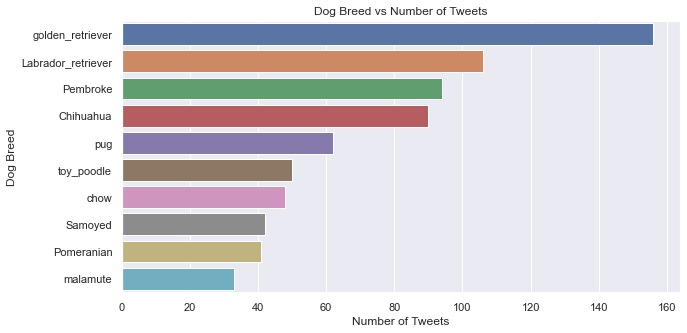

In [892]:
sns.set_theme(style="darkgrid")
plt.figure(figsize=(10, 5))
plt.title("Dog Breed vs Number of Tweets")
ax=sns.barplot(x = 'tweet_id',
            y = 'dog_breed',
            data = df_breed[:10],
            ci = 0)
ax.set(xlabel="Number of Tweets", ylabel = "Dog Breed")
plt.show()

It is clearly seen that the most tweeted dog breeds are golden_retriever, Labrador_retriever and Pembroke respectively.

**Which dog breeds are most popular from year to year?**

In [893]:
twitter_master_df['temp_year']=twitter_master_df['tweet_date'].astype('str').str[:4]

In [894]:
twitter_master_df_2=twitter_master_df[twitter_master_df['dog_breed']!='No Breed']

In [895]:
c=twitter_master_df_2.groupby(['temp_year']).apply(lambda x: (x.groupby('dog_breed')
                                      .count()
                                      .sort_values(by='tweet_id', ascending=False))
                                     .head(3))['tweet_id']
pd.DataFrame(c)

tweet_id
temp_year dog_breed                   
2015      Chihuahua                 41
          golden_retriever          32
          Labrador_retriever        29
2016      golden_retriever          90
          Pembroke                  51
          Labrador_retriever        51
2017      golden_retriever          34
          Labrador_retriever        26
          Pembroke                  23

It can be said that golden_retriever remained popular in 2016 and 2017. When rankings were examined, it was seen that breeds that were in top 5 in general changed places for themselves.

**which dog stage has a higher rating?**

In [896]:
masterRet=twitter_master_df.groupby('dog_stage').agg({'average_rating': ['mean', 'count']})
masterRet['average_rating'].sort_values(by=['mean'],ascending=False).head(10)

,mean,count
dog_stage,,
puppo,1.204348,23
doggo,1.188889,63
floofer,1.187500,8
other,1.180326,1668
pupper,1.072727,209


**which dog stage tweets have received much favorites?**

In [897]:
#favorite_number vs dog_stage
masterRet=twitter_master_df.groupby('dog_stage').agg({'favorite_number': ['mean', 'count']})
masterRet['favorite_number'].sort_values(by=['mean'],ascending=False).head(10)

,mean,count
dog_stage,,
puppo,22723.913043,23
doggo,19356.380952,63
floofer,13701.375000,8
other,8527.494604,1668
pupper,7479.019139,209


'puppo' phase were clearly seen to be in first place both as favorites and as rating.

**which dog breeds have higher ratings?**

In [898]:
masterRet=twitter_master_df.groupby('dog_breed').agg({'average_rating': ['mean', 'count']})
rateDog=masterRet['average_rating'].sort_values(by=['mean'],ascending=False)
rateDog.head(10)

,mean,count
dog_breed,,
clumber,2.700000,1
No Breed,1.615410,305
Bouvier_des_Flandres,1.300000,1
Pomeranian,1.253659,41
Saluki,1.250000,4
briard,1.233333,3
Tibetan_mastiff,1.225000,4
Border_terrier,1.214286,7
standard_schnauzer,1.200000,1


If we consider tweet count in average rating rank?

In [899]:
rateDog[rateDog['count']>10][1:10]

,mean,count
dog_breed,,
Pomeranian,1.253659,41
Samoyed,1.169048,42
golden_retriever,1.167607,156
kuvasz,1.152941,17
Great_Pyrenees,1.146667,15
Pembroke,1.142553,94
chow,1.141667,48
Eskimo_dog,1.140909,22
cocker_spaniel,1.133333,30


More clear results were observed when we added number of tweets to dog ratings analysis. </br>
Pomeranian, Samoyed, golden_retriever, Pembroke are in top 10 with received most favorites. They are also in top 10 in most popular tweet list.